In [40]:
import numpy as np
from scipy.integrate import ode
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import emcee
from scipy.interpolate import NearestNDInterpolator
import pandas as pd

%matplotlib inline

In [52]:
#Define the redshift evolution of f_esc
f_esc_flag ='Power'
#data_type = "tau_only"
data_type = "marg_cosmo"

directory = '/Users/laynep/work/reionization/importance_sampler/python_implementation/'

if f_esc_flag == 'Power':
    
    def f_esc_funct(z,f_esc):
        f6 = f_esc[0]
        alpha = f_esc[1]
        
        out = f6*((1.0+z)/7.0)**alpha
        
        return np.min([np.max([0.0, out]), 1.0])
    
elif f_esc_flag == 'Polint':
    
    def f_esc_funct(z,f_esc):
        z_pos = np.linspace(3,20,10)
        
        if z< np.min(z_pos):
            return f_esc[0]
        elif z>np.max(z_pos):
            return f_esc[-1]
        else:
            f_funct = interp1d(z_pos, f_esc, kind='cubic')
            return np.min([np.max([0.0, f_funct(z)]), 1.0])

else:
    
    raise Exception('This f_esc function not implemented.')

#Fixed params
class global_params():
    
    def __init__(self):
        """Some general set up required."""
    
        self.m_bright = -35.0
        self.photon_norm_factor = 25.2
        
        self.T0_IGM = 2.0e4
        self.X_h = 0.747
        self.HeII_z = 3.5
        
        self.schecter_fname = directory + 'schecter_params.txt'
        schecter = np.loadtxt(self.schecter_fname)
        self.z_list = schecter[:,0]
        self.phi_list = schecter[:,1]
        self.m_list = schecter[:,2]
        self.alpha_list = schecter[:,3]
        
        self.mpc_to_cm = 3.086e24
        self.mass_h = 1.674e-24
        self.G_newton = 6.674e-8
        self.sigT = 6.6524e-25
        self.c = 2.998e10
        
        #Can also be iterated over if edit the unpack routine
        self.h = 0.7
        #self.ommh2 = 0.27*self.h**2
        self.ommh2 = 0.3*self.h**2
        self.ombh2 = 0.045*self.h**2
        
        if data_type == "tau_only":
            self.tau_post_fname =directory + 'posterior_tauonly.txt'
            tau_pdf = np.loadtxt(self.tau_post_fname)
            self.tau_list = tau_pdf[:,1]
            self.taupdf_list = tau_pdf[:,0]
        elif data_type == "marg_cosmo":
            self.data_margcosmo = pd.read_csv(directory + 'total_margcosmo.txt')

    
globe = global_params()

def unpack(x):
    
    y = np.array(x)
    
    if f_esc_flag=="Power":
        offset=2
        f_esc = x[0:offset]
    else:
        offset=10
        f_esc = x[0:offset]
        
    c_hii = x[offset]
    m_sf = x[offset+1]
    m_evol = x[offset+2]
    
    #Can get these either from x or from fixed
    ombh2 = globe.ombh2
    ommh2 = globe.ommh2
    return f_esc, c_hii, m_sf, m_evol, ombh2, ommh2

def mag_to_lumin(mag):
    """Converts AB magnitude to luminosity."""
    conv_factor = 4.345e20
    return float(conv_factor*10.0**(-mag/2.5))

def schecter_params(z):
    """Get the Schecter parameters as a function of redshift.  Based on the Scorch I paper."""

    #Use range limits if z extends beyond the interpolation list
    if z<np.min(globe.z_list):
        phi_star, m_star, alpha_star = globe.phi_list[0],globe.m_list[0],globe.alpha_list[0]
    elif z>np.max(globe.z_list):
        phi_star, m_star, alpha_star = globe.phi_list[-1], globe.m_list[-1], globe.alpha_list[-1]

    else:
        #Interpolate
        phi, m, alpha = map(lambda x: interp1d(globe.z_list,x,kind='cubic'),
                            [globe.phi_list, globe.m_list, globe.alpha_list])

        phi_star, m_star, alpha_star = phi(z), m(z), alpha(z)

    L_star = mag_to_lumin(m_star)

    #Convert phi into cgs --- currently Mpc^-3
    phi_star *= globe.mpc_to_cm**(-3.0)

    return float(phi_star), float(L_star), float(alpha_star)

def ioniz_emiss(z, m_sf, m_evol, f_esc):
    m_faint = m_sf + m_evol*(z-6.0)
    L_bright = mag_to_lumin(globe.m_bright)
    L_faint = mag_to_lumin(m_faint)

    phi_star, L_star, alpha = schecter_params(z)

    prefactor = -2.5/np.log(10.0)
    prefactor *= 10.0**(globe.photon_norm_factor)
    prefactor *= f_esc_funct(z, f_esc)*phi_star*L_star

    return prefactor*(alpha+1.0)**(-1.0)*(L_faint/L_star)**(alpha+1.0)

def t_recomb(z, c_hii):
    prefactor = 0.93*1e9*365.25*24.0*60.0*60.0 #Gyr to sec
    c_term = (c_hii/3.0)**(-1.0)
    t_term = (globe.T0_IGM/2.0e4)**0.7
    z_term = ((1.0+z)/7.0)**(-3.0)
    return prefactor*c_term*t_term*z_term

def comov_h_density(ombh2):
    prefactor = (3.0/8.0/np.pi/globe.G_newton)*1e4*(1e5/globe.mpc_to_cm)**2

    return prefactor*(globe.X_h/globe.mass_h)*ombh2

def hubble(z, ommh2):
    h2 = 1e2**2 *(ommh2*(1.0+z)**3.0)
    return np.sqrt(h2)*1e5/globe.mpc_to_cm

def electron_from_helium(z):
    if z > globe.HeII_z:
        return 1.0
    else:
        return 2.0
          

def tau_calculator(x):
    """Calculate the Thomson optical depth from the galaxy reionization parameters."""
    f_esc, c_hii, m_sf, m_evol, ombh2, ommh2 = unpack(x)
    
    Q0 = 2.1979099400481504e-004 #From CAMB, connects to residual ionization from recombination
    
    def derivs(z, Q):
        """The Q'(z0) = derivs(z, Q)"""
        
        hub = hubble(z, ommh2)
        trec = t_recomb(z, c_hii)
        nh = comov_h_density(ombh2)
        ion = ioniz_emiss(z,m_sf, m_evol, f_esc)
        
        return -1.0*(1.0/hub/(1.0+z))*(ion/nh/(1.0+z)**3.0 - Q/trec)
    
    #Solve the ODE for the volume filling factor Q
    solver = ode(derivs).set_integrator("vode")
    
    z0= 25.0
    solver.set_initial_value(Q0,z0)
    
    dz = -z0/100.0
    z_ode = []
    Q_ode = []
    while solver.successful() and solver.t > 0.0 and solver.y<1.0 and solver.y>0.0:
        solver.integrate(solver.t + dz)
        z_ode.append(solver.t)
        Q_ode.append(solver.y)
        #print solver.t, solver.y
        
        
    #Set up interpolating function
    naive_Q = interp1d(np.array(z_ode),np.array(Q_ode).flatten(),kind='cubic')
    def Q_of_z(z):
        #Volume filling factor
        if z<np.min(z_ode):
            Q=1.0
        elif z > np.max(z_ode):
            Q=Q_ode[0]
        else:
            Q = np.max([np.min([1.0,naive_Q(z)]),0.0])
        
        return Q
        
    #Integrate Q to get \tau
    def tau_integrand(z):
        prefactor = globe.sigT*globe.c*1e-2*comov_h_density(ombh2)*globe.mpc_to_cm/1e5/np.sqrt(ommh2)
        
        integrand = Q_of_z(z)*np.sqrt(1.0+z)*(1.0+(1.0-globe.X_h)/(4.0*globe.X_h)*electron_from_helium(z))
        
        return prefactor*integrand
    
    #Calculate \tau
    (tau, dtau) = quad(tau_integrand, 0.0, z0)
    
    if dtau > 1e-4:
        raise Exception('tau integrator has large error.')
    
    return tau, Q_of_z


def logprior(x):
    f_esc, c_hii, m_sf, m_evol, ombh2, ommh2 = unpack(x)
    
    bad = False
    const = 1.0  #Unnormalized prior

    #Prior ranges
    if f_esc_flag=='Power':
        if f_esc[0]<0.0 or f_esc[0]>1.0:
            bad = True
        elif f_esc[1]<0.0 or f_esc[1]>4.0:
            bad = True
    elif f_esc_flag=="Polint":
        if any(f_esc<0.0) or any(f_esc>1.0):
            bad = True
    if c_hii<1.0 or c_hii>5.0:
        bad = True
    if m_sf<-11.0 or m_sf >-9.5:
        bad = True
    if m_evol <-0.035 or m_evol>-0.031:
        bad = True
        
    if bad:
        return -np.inf
    else:
        return const

def loglike(tau,x):
    f_esc, c_hii, m_sf, m_evol, ombh2, ommh2 = unpack(x)
    
    print "tau, ombh2, ommh2", tau, ombh2, ommh2
    
    if data_type=="tau_only":

        if tau<np.min(globe.tau_list) or tau > np.max(globe.tau_list):
            return -np.inf
        else:
            
            #Likelihood just from the LCDM tau values with cosmo params fixed
            post_funct = interp1d(globe.tau_list, globe.taupdf_list,kind='cubic')

            #print "This is post_funct", post_funct(tau)
            post = np.max([0.0,post_funct(tau)])

            if post==0.0:
                return -np.inf
            else:
                return np.log(post)
            
    elif data_type == "marg_cosmo":
        
        print "ranges"
        print tau, np.min(globe.data_margcosmo['tau']), np.max(globe.data_margcosmo['tau'])
        print ombh2, np.min(globe.data_margcosmo['omegabh2']), np.max(globe.data_margcosmo['omegabh2'])
        print ommh2, np.min(globe.data_margcosmo['omegamh2']), np.max(globe.data_margcosmo['omegamh2'])

        
        if tau<np.min(globe.data_margcosmo['tau']) or tau > np.max(globe.data_margcosmo['tau']):
            return -np.inf
        elif ombh2<np.min(globe.data_margcosmo['omegabh2']) or ombh2 > np.max(globe.data_margcosmo['omegabh2']):
            return -np.inf
        elif ommh2<np.min(globe.data_margcosmo['omegamh2']) or ommh2 > np.max(globe.data_margcosmo['omegamh2']):
            return -np.inf
        else:

            post_funct = NearestNDInterpolator(
                np.array(globe.data_margcosmo[['omegabh2','omegamh2','tau']]),
                np.array(globe.data_margcosmo['like']))
            
            post = np.max([0.0,post_funct([ombh2,ommh2,tau])])
            
            if post==0.0:
                return -np.inf
            else:
                return np.log(post)

    else:
        raise Exception('This data type not supported.')
    

def logpost(x):

    f_esc, c_hii, m_sf, m_evol, ombh2, ommh2 = unpack(x)
        
    prior = logprior(x)
    
    #Likelihood
    
    tau, Q = tau_calculator(x)
    
    #Implement 2sig constraint from 1411.5375 as a step function
    if Q(z=5.9)<0.84:
        like = -np.inf
    
    else:
        like = loglike(tau, x)
    
    #print "tau and Q(5.9)", tau, Q(5.9)
    
    
    return prior + like


xvect = [0.8, 4.0, 4.0, -10.0,-0.032]

logpost(xvect)



tau, ombh2, ommh2 0.0921279282763 0.02205 0.147
ranges
0.0921279282763 0.01233959 0.150188
0.02205 0.02137299 0.02292934
0.147 0.1374835 0.1480556


9.6192677141078775

In [38]:
#Emcee sampler
from emcee.utils import MPIPool

ndim = 5
nwalkers = 250

pool = MPIPool()
if not pool.is_master():
    pool.wait()
    sys.exit(0)

p0=[]
for walker in xrange(nwalkers):
    p0_here = []
    p0_here.append(np.random.rand()) #f_6
    p0_here.append(np.random.rand()*4.0) #\alpha
    p0_here.append(np.random.rand()*(5.0-1.0)+1.0) #C_HII
    p0_here.append(np.random.rand()*(-9.5+11.0) - 11.0) #M_SF
    p0_here.append(np.random.rand()*(-0.031 + 0.035) - 0.035) #M_SF'
    p0.append(p0_here)
p0=np.array(p0)

#sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, threads=8)
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, pool=pool)

pos, prob, state = sampler.run_mcmc(p0, 10)

pool.close()
#import matplotlib.pyplot as pl
#%matplotlib inline

#for i in range(ndim):
#    pl.figure()
#    pl.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
#    pl.title("Dimension {0:d}".format(i))


ValueError: Tried to create an MPI pool, but there was only one MPI process available. Need at least two.

In [39]:
MPIPool?

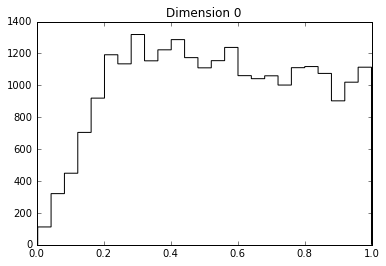

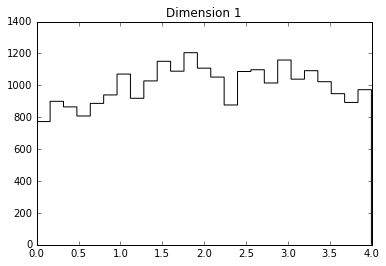

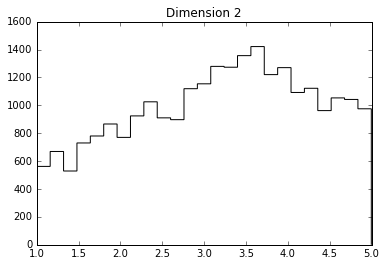

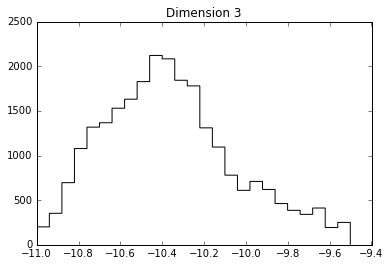

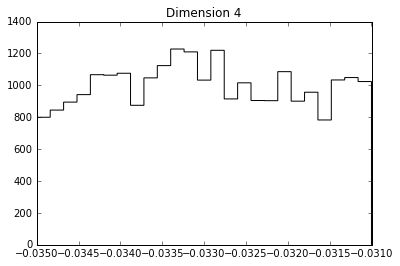

In [37]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 25, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

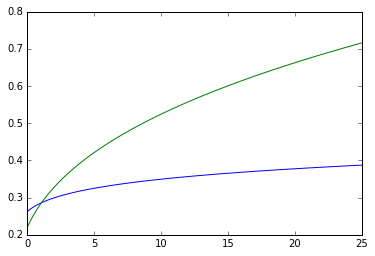

In [36]:
xplot = np.linspace(0,25.0,100)
#yplot = map(lambda x: f_esc_funct(x, np.array([0.8,4.0])), xplot)
#yplot2 = map(lambda x: f_esc_funct(x, np.array([0.4005,4.0])), xplot)

f1=np.random.rand(10)
f2=np.random.rand(10)
yplot = map(lambda x: f_esc_funct(x, f1), xplot)
yplot2 = map(lambda x: f_esc_funct(x, f2), xplot)

plt.plot(xplot,yplot)
plt.plot(xplot,yplot2)